# Deploying on a test set
- Use model to calculate embeddings (using eval mode specifically and with no gradient updating)
- NOTE: Right now, we have to have the input data in the correct format: a spectrogram/chromagram/tempogram (generically called "gram"). So for any deployment, we'll have to do preprocessing in the streamlit app for example. OR we can have a set of say 10-15 sample songs you can compare where we've already done all of the calculations.


In [108]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from dotenv import dotenv_values 
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pickle as pkl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset

from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score, roc_curve
from transformers import Wav2Vec2Model

import torch.optim as optim
from pydub import AudioSegment
import io

### Extract Embeddings

In [44]:
# Define pretrained resnet from Torch Vision resnet 18
class ResNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=128, dropout_rate=0.5):
        # get resnet super class
        super(ResNetEmbedding, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        # Change structure of first layer to take non RGB images, rest of params same as default
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        # Set the last fully connected to a set dimension "embedding_dim" instead of default 1000
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.resnet(x)
        return F.normalize(x, p=2, dim=1)

In [58]:
# How to load the model later using just the state dictionary
model = ResNetEmbedding()  # Make sure this matches the architecture you used
model.load_state_dict(torch.load('../modeling/resnet_output/resnet18_model_weights.pth', map_location=torch.device('cpu')))

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNetEmbedding(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [93]:
def compute_distance(model, row, use_model=True):
    song_1 = row['song_1']
    song_2 = row['song_2']
    
    # Assuming the input for deployment is already a mel spec y values
    mel_tensor_1 = torch.tensor(song_1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    mel_tensor_2 = torch.tensor(song_2, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # Get with model
    if use_model:
        # Get the embedding from the model. No need to normalize, since forward pass does that
        with torch.no_grad():
            embedding_1 = model(mel_tensor_1)
            embedding_2 = model(mel_tensor_2)

    else:
        # Flatten to get rid of dimensions, then unqueeze to make 2D with batch dimension 
        no_model_embedding_1 = F.normalize(mel_tensor_1.flatten().unsqueeze(0), p=2, dim=1)
        no_model_embedding_2 = F.normalize(mel_tensor_2.flatten().unsqueeze(0), p=2, dim=1)

    euclidean_distance = torch.dist(embedding_1, embedding_2).item()
    #cosine_similarity = F.cosine_similarity(embedding_1, embedding_2).item()
    return euclidean_distance

def get_label(row, threshold=0.5):
    if row['euclidean_distance'] > threshold:
        return 1
    else:
        return 0

In [94]:
# Load dataframe we made for deployment
deploy_df = pd.read_pickle('../data/paired_songs_spectrograms_test.pkl')
deploy_df.head(2)

,song_title_1,artist_1,album_1,song_1,song_title_2,artist_2,album_2,song_2,label
0,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-49.7658, -50.9627, -44.81154, -38.146698, -...",Claudette,everly_brothers,The_Fabulous_Style_of,"[[-26.068644, -23.991093, -23.518074, -26.1214...",1
1,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-49.7658, -50.9627, -44.81154, -38.146698, -...",12-Day_Tripper,/Users/reggiebain/erdos/song-similarity-erdos/...,1,"[[-39.67006, -36.35625, -30.621237, -25.635677...",0


In [101]:
tqdm.pandas(desc=f"Computing Distances...")
deploy_df['euclidean_distance'] = deploy_df.progress_apply(lambda row: compute_distance(model, row), axis=1)

Computing Distances...:   0%|          | 0/154 [00:00<?, ?it/s]

Computing Distances...: 100%|██████████| 154/154 [02:28<00:00,  1.04it/s]


In [102]:
deploy_df.head()

,song_title_1,artist_1,album_1,song_1,song_title_2,artist_2,album_2,song_2,label,euclidean_distance,cosine_similarity,deploy_label
0,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-49.7658, -50.9627, -44.81154, -38.146698, -...",Claudette,everly_brothers,The_Fabulous_Style_of,"[[-26.068644, -23.991093, -23.518074, -26.1214...",1,0.715550,0.476958,0
1,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-49.7658, -50.9627, -44.81154, -38.146698, -...",12-Day_Tripper,/Users/reggiebain/erdos/song-similarity-erdos/...,1,"[[-39.67006, -36.35625, -30.621237, -25.635677...",0,0.476958,0.476958,0
2,I_Don_t_Want_To_Miss_A_Thing,aerosmith,Armageddon_Original_Soundtrack_,"[[-16.02195, -15.988646, -18.057266, -15.57520...",I_Don_t_Want_To_Miss_A_Thing,aerosmith,Armageddon_Original_Soundtrack_,"[[-26.193792, -20.062042, -20.986141, -20.8752...",1,0.658964,0.476958,0
3,I_Don_t_Want_To_Miss_A_Thing,aerosmith,Armageddon_Original_Soundtrack_,"[[-16.02195, -15.988646, -18.057266, -15.57520...",06-Enjoy_The_Silence,/Users/reggiebain/erdos/song-similarity-erdos/...,Violator,"[[-14.437675, -12.7644005, -15.01837, -17.1538...",0,0.486238,0.476958,0
4,Happiness_is_a_Warm_Gun,beatles,White_Album_Disc_1,"[[-33.150192, -37.771618, -41.097336, -43.5215...",Happiness_is_a_Warm_Gun,beatles,White_Album_Disc_1,"[[-19.768545, -16.877508, -16.295105, -17.8528...",1,0.499123,0.476958,0


In [103]:
# Compare means of means based on label
print(f"Mean Distance of Covers: {deploy_df[deploy_df.label == 1].euclidean_distance.mean()}")
print(f"Mean Distance of NOT Covers: {deploy_df[deploy_df.label == 0].euclidean_distance.mean()}")
print(f"Mean Sim of Covers: {deploy_df[deploy_df.label == 1].cosine_similarity.mean()}")
print(f"Mean Sim of NOT Covers: {deploy_df[deploy_df.label == 0].cosine_similarity.mean()}")

Mean Distance of Covers: 0.6142864316314846
Mean Distance of NOT Covers: 0.6165727419512612
Mean Sim of Covers: 0.4769582152366638
Mean Sim of NOT Covers: 0.4769582152366638


In [104]:
tqdm.pandas(desc=f"Getting Labels using mean threshold...")
deploy_df['deploy_label'] = deploy_df.apply(lambda row: get_label(row, threshold=deploy_df['euclidean_distance'].mean()), axis=1) 

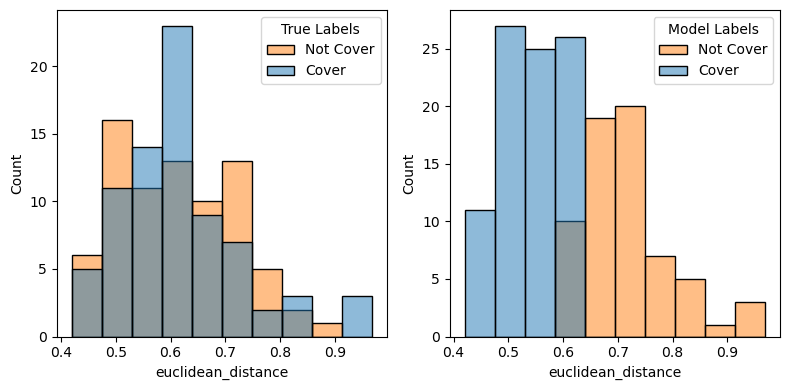

In [105]:
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns.histplot(data=deploy_df, x='euclidean_distance', hue='label', ax=axes[0])
sns.histplot(data=deploy_df, x='euclidean_distance', hue='deploy_label', ax=axes[1])
axes[0].legend(title='True Labels', labels=['Not Cover', 'Cover'])
axes[1].legend(title='Model Labels', labels=['Not Cover', 'Cover'])
plt.tight_layout()
plt.show()

In [106]:
# Calculate accuracy, precision, recall, F1
accuracy = accuracy_score(deploy_df['label'], deploy_df['deploy_label'])
precision = precision_score(deploy_df['label'], deploy_df['deploy_label'])
f1 = f1_score(deploy_df['label'], deploy_df['deploy_label'])
recall = recall_score(deploy_df['label'], deploy_df['deploy_label'])

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f"Recall: {recall}")


Accuracy: 0.5195
Precision: 0.5231
F1 Score: 0.4789
Recall: 0.44155844155844154


### Try Nearest Neighbor Accuracy and other Triplet Validation

In [107]:
# Load the original test files with triplets
triplet_df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos/data/test_set_covers.pkl')
triplet_df.head(2)

,song_title,artist,album,song,anchors,positives,negatives,neg_song,neg_artist,neg_album
0,Claudette,everly_brothers,The_Fabulous_Style_of,01-Claudette,"[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-80.0, -80.0, -80.0, -61.775627, -48.010227,...","[[-80.0, -80.0, -80.0, -80.0, -76.417206, -74....",03-Addicted_To_Love,/Users/reggiebain/erdos/song-similarity-erdos/...,Riptide
1,I_Don_t_Want_To_Miss_A_Thing,aerosmith,Armageddon_Original_Soundtrack_,01-I_Don_t_Want_To_Miss_A_Thing,"[[-80.0, -80.0, -80.0, -79.25159, -56.510735, ...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...","[[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...",09-Summertime_Blues,/Users/reggiebain/erdos/song-similarity-erdos/...,Surfin_USA_Surfin_Safari


In [114]:
# Find if positive or negative sample is closer. 1 if pos closer 0 if not.
def find_closer_neighbor(row):
    anchor, positive, negative = row['anchors'], row['positives'], row['negatives']

    # Assuming the input for deployment is already a mel spec y values
    anchor_tensor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    positive_tensor = torch.tensor(positive, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    negative_tensor = torch.tensor(negative, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    
    with torch.no_grad():
        anchor_embedding = model(anchor_tensor)
        positive_embedding = model(positive_tensor)
        negative_embedding = model(negative_tensor)

    anchor_positive_dist = torch.dist(anchor_embedding, positive_embedding).item()
    anchor_negative_dist = torch.dist(anchor_embedding, negative_embedding).item()
    #cosine_similarity = F.cosine_similarity(embedding_1, embedding_2).item()
    
    closer_neighbor = 1 if anchor_positive_dist > anchor_negative_dist else 0
    return closer_neighbor

# Calculate the accuracy given a column
def get_nn_accuracy(df):
    return df['closer_neighbor'].mean()    

# Calculate baseline accuracy by randomly guessing
def get_baseline_nn_accuracy(df):
    random_guesses = np.random.choice([0, 1], size=len(df))
    baseline_accuracy = (df['closer_neighbor'] == random_guesses).mean()
    return baseline_accuracy

def get_pct_improve(nn, baseline):
    return (nn - baseline)/baseline * 100

In [116]:
tqdm.pandas(desc=f"Calculating triplet inner products...")
triplet_df['closer_neighbor'] = triplet_df.progress_apply(lambda row: find_closer_neighbor(row), axis=1)
nn_accuracy = get_nn_accuracy(triplet_df)
baseline_accuracy = get_baseline_nn_accuracy(triplet_df)
pct_improve = get_pct_improve(nn_accuracy, baseline_accuracy)

Calculating triplet inner products...:   0%|          | 0/77 [00:00<?, ?it/s]

Calculating triplet inner products...: 100%|██████████| 77/77 [07:21<00:00,  5.74s/it]


In [117]:
print(f"Nearest Neighbor Accuracy: {nn_accuracy*100:.4f}%")
print(f"Baseline Accuracy: {baseline_accuracy*100:.4f}%")
print(f"Model % Improvement: {pct_improve:.4f}%")

Nearest Neighbor Accuracy: 38.9610%
Baseline Accuracy: 45.4545%
Model % Improvement: -14.2857%


In [ ]:
# Function to calculate cosine similarity between two tensors
def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a, b)

# Function to calculate accuracy and predicted scores for each row
def calculate_row_metrics(row):
    anchor = torch.tensor(row['anchor'])
    positive = torch.tensor(row['positive'])
    negative = torch.tensor(row['negative'])
    
    pos_sim = cosine_similarity(anchor, positive).item()
    neg_sim = cosine_similarity(anchor, negative).item()
    
    # Determine if the positive is closer than the negative
    accuracy = 1 if pos_sim > neg_sim else 0
    
    return pd.Series({
        'accuracy': accuracy,
        'true_labels': [1, 0],  # 1 for positive, 0 for negative
        'predicted_scores': [pos_sim, neg_sim]
    })

# Assuming your test DataFrame looks something like this:
# df_test = pd.DataFrame({
#     'anchor': [...],    # anchor spectrograms
#     'positive': [...],  # positive spectrograms
#     'negative': [...],  # negative spectrograms
# })

# Apply the function to each row
results = df_test.apply(calculate_row_metrics, axis=1)

# Flatten the true_labels and predicted_scores
true_labels = np.hstack(results['true_labels'].values)
predicted_scores = np.hstack(results['predicted_scores'].values)

# Calculate nearest neighbor accuracy
nearest_neighbor_accuracy = results['accuracy'].mean()
print(f'Nearest Neighbor Accuracy: {nearest_neighbor_accuracy:.4f}')

# Calculate baseline accuracy by randomly guessing
random_guesses = np.random.choice([0, 1], size=len(results))
baseline_accuracy = (results['accuracy'] == random_guesses).mean()
print(f'Baseline Accuracy (Random Guessing): {baseline_accuracy:.4f}')

# Calculate and plot the ROC-AUC curve
roc_auc = roc_auc_score(true_labels, predicted_scores)
fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC-AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='lower right')
plt.show()


### Search Spotify for Track to Analyze

In [5]:
# Load stuff from .env file
env_vars = dotenv_values('.env')

client_credentials_manager = SpotifyClientCredentials(
    client_id=os.getenv("SPOTIFY_CLIENT_ID"),
    client_secret=os.getenv("SPOTIFY_CLIENT_SECRET"),
)
# Get Spotify api client and apply to df
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [6]:
# Function to get the preview URL of a song based on artist name and song title
#@retry(wait=wait_exponential(multiplier=1, min=4, max=60), stop=stop_after_attempt(10))
def search_track(artist_name, track_name, sp, rate_limit = 1.0):
    # Search for the track
    result = sp.search(q=f'artist:{artist_name} track:{track_name}', type='track', limit=1)
    if result['tracks']['items']:
        # Return the preview URL if found
        return result['tracks']['items'][0]['preview_url']
    print('Arist/Track not found...')
    return None    

In [9]:
track1_name = 'Under Pressure'
track1_artist = 'Bowie'
track2_name = 'Rosanna'
track2_artist = 'Toto'
track1 = search_track(track1_artist, track1_name, sp)
track2 = search_track(track1_artist, track1_name, sp)

In [10]:
track2

In [30]:
artist_name = 'Robin Thicke'
track_name = 'Surfin USA'
#result = sp.search(q=f'artist:{artist_name} track:{track_name}', type='track', limit=1)
result = sp.search(q=f'track:{track_name}', type='track', limit=1)
preview = None
for item in result['tracks']['items']:
    if item['preview_url'] is not None:
        preview = item['preview_url']
        break
preview   
    

In [42]:
for track in result['tracks']:
    print(f"{track['items']}")

TypeError: string indices must be integers, not 'str'

In [41]:
result['tracks']['items']

[{'album': {'album_type': 'album',
   'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3oDbviiivRWhXwIE8hxkVV'},
     'href': 'https://api.spotify.com/v1/artists/3oDbviiivRWhXwIE8hxkVV',
     'id': '3oDbviiivRWhXwIE8hxkVV',
     'name': 'The Beach Boys',
     'type': 'artist',
     'uri': 'spotify:artist:3oDbviiivRWhXwIE8hxkVV'}],
   'available_markets': ['AR',
    'AU',
    'AT',
    'BE',
    'BO',
    'BR',
    'BG',
    'CA',
    'CL',
    'CO',
    'CR',
    'CY',
    'CZ',
    'DK',
    'DO',
    'DE',
    'EC',
    'EE',
    'SV',
    'FI',
    'FR',
    'GR',
    'GT',
    'HN',
    'HK',
    'HU',
    'IS',
    'IE',
    'IT',
    'LV',
    'LT',
    'LU',
    'MY',
    'MT',
    'MX',
    'NL',
    'NZ',
    'NI',
    'NO',
    'PA',
    'PY',
    'PE',
    'PH',
    'PL',
    'PT',
    'SG',
    'SK',
    'ES',
    'SE',
    'CH',
    'TW',
    'TR',
    'UY',
    'US',
    'GB',
    'AD',
    'LI',
    'MC',
    'ID',
    'JP',
    'TH',
    'VN',


## Deploy Model on Covers Set

In [14]:
# Define pretrained resnet from Torch Vision resnet 18
class ResNetEmbedding(nn.Module):
    def __init__(self, embedding_dim=128, dropout_rate=0.5):
        # get resnet super class
        super(ResNetEmbedding, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        # Change structure of first layer to take non RGB images, rest of params same as default
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.dropout = nn.Dropout(p=dropout_rate)
        # Set the last fully connected to a set dimension "embedding_dim" instead of default 1000
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embedding_dim)

    def forward(self, x):
        x = self.resnet(x)
        return F.normalize(x, p=2, dim=1)

In [15]:
# How to load the model later using just the state dictionary
model = ResNetEmbedding()  # Make sure this matches the architecture you used
model.load_state_dict(torch.load('../modeling/resnet_output/resnet18_model_weights.pth', map_location=torch.device('cpu')))

# If using a GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNetEmbedding(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [16]:
df = pd.read_pickle('/Users/reggiebain/erdos/song-similarity-erdos/data/paired_songs_spectrograms_test.pkl')
df.head(2)

,song_title_1,artist_1,album_1,song_1,song_title_2,artist_2,album_2,song_2,label
0,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-20.06596, -25.361977, -36.63954, -36.95588,...",Claudette,everly_brothers,The_Fabulous_Style_of,"[[-14.384415, -11.793728, -15.675781, -15.1625...",1
1,Claudette,everly_brothers,The_Fabulous_Style_of,"[[-20.06596, -25.361977, -36.63954, -36.95588,...",04-_I_Can_t_Get_No_Satisfaction,/Users/reggiebain/erdos/song-similarity-erdos/...,Oops_I_Did_It_Again,"[[-55.93022, -58.752205, -59.60171, -51.639885...",0


In [17]:
def compute_euclidean_distance(embedding1, embedding2):
    euclidean_dist = torch.dist(embedding1, embedding2).item()
    return euclidean_dist    


In [12]:
df.iloc[0,:]['song_1']

array([[-20.06596 , -25.361977, -36.63954 , ..., -35.24062 , -36.01107 ,
        -40.109497],
       [-12.532795, -10.82708 , -13.759367, ..., -28.167135, -32.259403,
        -33.94999 ],
       [-13.140096, -10.371328, -11.851125, ..., -27.042032, -29.600811,
        -27.458254],
       ...,
       [-66.633286, -72.68074 , -80.      , ..., -80.      , -80.      ,
        -79.215355],
       [-66.67272 , -72.71942 , -80.      , ..., -80.      , -80.      ,
        -79.35535 ],
       [-66.6978  , -72.74404 , -80.      , ..., -80.      , -80.      ,
        -79.44292 ]], dtype=float32)

In [6]:
df['distance'] = df.apply(lambda row: compute_euclidean_distance(row['song_1'], row['song_2']))

KeyError: 'song_1'